In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch

# torch.set_float32_matmul_precision('medium')
import logging

import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from nltk.stem.snowball import SnowballStemmer
from pytorch_lightning import Trainer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
from tqdm import tqdm

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import pickle

import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm.auto import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Load data

In [2]:
train = fetch_20newsgroups(subset='train', shuffle=True)
# with open('20_newsgroups_train.pickle', 'rb') as f:
#     train = pickle.load(f)
print(dir(train))
print("Number of instances: ", len(train.data))
print("Length of particular instance: ", len(train.data[0]))
print("Target names:", train.target_names)
print("------------------------------------")
print("Label:", train.target_names[train.target[0]])
print("Text:", train.data[0][:250])
print("------------------------------------")

['DESCR', 'data', 'filenames', 'target', 'target_names']
11314
Target names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
------------------------------------
Label: rec.autos
Text: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the ot
------------------------------------


Preprocessing

In [3]:
# import nltk

# nltk.data.path.append('nltk_data')
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

preprocess_pipeline = Pipeline([
    ("vect", StemmedCountVectorizer(stop_words="english", max_features=20000)),
    ("tfidf", TfidfTransformer()),
])

In [4]:
train_data = preprocess_pipeline.fit_transform(train.data)

In [5]:
print(f"({len(train.data)}, {len(train.data[0])})")
print(train_data.shape)
train_labels = train.target
print(train_labels.shape)
print(train_labels[0])
number_of_labels = len(train.target_names)
print(number_of_labels)

(11314, 721)
(11314, 20000)
(11314,)
7
20


Model definition

In [6]:
class DenseTextClassifier(pl.LightningModule):
    def __init__(self, network, loss_function, lr):
        super().__init__()
        self.network = network
        self.loss_function = loss_function
        self.lr = lr
        self.history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=number_of_labels)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, _):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        acc = self.accuracy(torch.argmax(outputs, dim=1), labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, _):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)
        acc = self.accuracy(torch.argmax(outputs, dim=1), labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        self.history["train_loss"].append(self.trainer.logged_metrics.get("train_loss"))
        self.history["train_acc"].append(self.trainer.logged_metrics.get("train_acc"))

    def on_validation_epoch_end(self):
        self.history["val_loss"].append(self.trainer.logged_metrics.get("val_loss"))
        self.history["val_acc"].append(self.trainer.logged_metrics.get("val_acc"))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [7]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        return self.network(x)

Learning

In [8]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        bar.close()
        return bar

In [9]:
num_epochs = 20
input_size = train_data.shape[1]
output_size = number_of_labels
batch_size = 64
lr = 0.0001
loss_function = nn.CrossEntropyLoss()
k_folds = 5

data_tensor = torch.from_numpy(train_data.toarray()).float()
labels_tensor = torch.from_numpy(train_labels).long()
dataset = TensorDataset(data_tensor, labels_tensor)
history = []

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_ids, val_ids) in enumerate(kfold.split(data_tensor)):
    print(f"Fold: {fold}")
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids), num_workers=7)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_ids), num_workers=7)

    network = SimpleNet(input_size, output_size)
    model = DenseTextClassifier(network=network, loss_function=loss_function, lr=lr)

    trainer = Trainer(max_epochs=num_epochs, callbacks=[LitProgressBar()], num_sanity_val_steps=0)
    trainer.fit(model, train_loader, val_loader)
    history.append(model.history)

Fold: 0


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 1


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 2


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 3


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 4


Training: |          | 0/? [00:00<?, ?it/s]

Mean validation accuracy: 0.9089


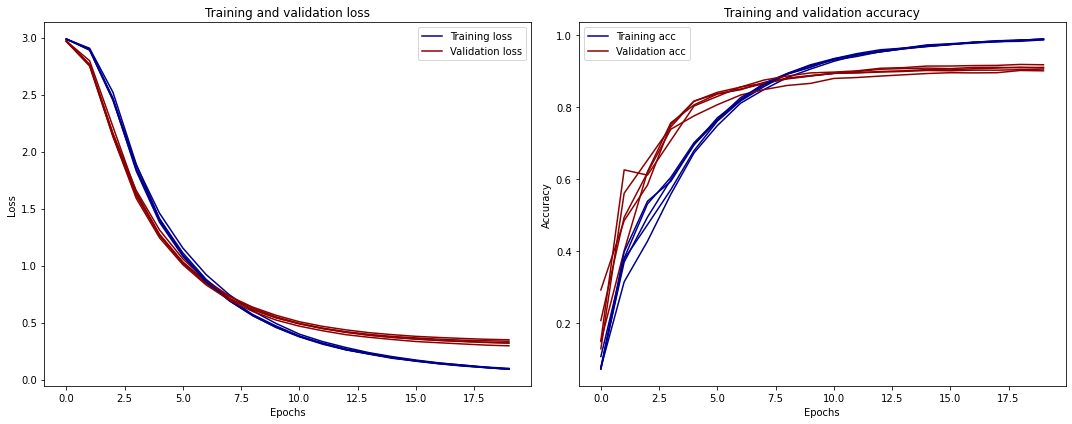

In [10]:
print(f"Mean validation accuracy: {np.mean([history[i]['val_acc'][-1].item() for i in range(k_folds)]):.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
for fold in range(k_folds):
    loss = [t.item() for t in history[fold]['train_loss']]
    val_loss = [t.item() for t in history[fold]['val_loss']]
    epochs = range(len(loss))
    ax1.plot(epochs, loss, label='Training loss' if fold == 0 else None, color="darkblue")
    ax1.plot(epochs, val_loss, label='Validation loss' if fold == 0 else None, color="darkred")

ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

for fold in range(k_folds):
    acc = [t.item() for t in history[fold]['train_acc']]
    val_acc = [t.item() for t in history[fold]['val_acc']]
    epochs = range(len(acc))
    ax2.plot(epochs, acc, label='Training acc' if fold == 0 else None, color="darkblue")
    ax2.plot(epochs, val_acc, label='Validation acc' if fold == 0 else None, color="darkred")

ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()